# Generate causal net data
In this notebook, as part of a project to learn about Bayesian (and causal) Networks, I generate synthetic data sets based on DAG's (directed acyclical graphs). I will assume Gaussian distributions, with linear relations between variables. I will also create binary data by thresholding the continuous Gaussian distributions.

Some references:
* [The Book of Why, Judea Pearl](https://www.amazon.com/Book-Why-Science-Cause-Effect/dp/046509760X)
* [A Technical Primer on Causality](https://medium.com/@akelleh/a-technical-primer-on-causality-181db2575e41)
* [Pomegranate Bayesian Networks Documentation](https://pomegranate.readthedocs.io/en/latest/BayesianNetwork.html#)

I will first generate data for the three fundamental building blocks of (causal) nets identified in Judea Pearl's work: chains, forks and colliders. I will then generate the more complex M-diagram (from e.g. The Book of Why by Pearl). Finally, I will make up my own diagram that contains a number of different types of relations between a target $Y$ and the features.

In a few cases, I will also briefly apply the [Pomegranate package](https://pomegranate.readthedocs.io/en/latest/index.html) to reconstruct a Bayesian Net DAG from the synthetic data.

In [64]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

In [66]:
sns.set()
sns.set_context('notebook', rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize':25,\
                                  'lines.linewidth':3})

# 1 - Chain
(cf. e.g. the book of why)

$$X_1 -> X_2 -> X_3$$

$$X_1 \sim N(\mu=0, \sigma=1)$$
$$X_2 \sim p(X_2 | X_1) = N(\mu=\alpha_{21} X_1, \sigma=\sigma_{\epsilon_2})$$
$$X_3 \sim p(X_3 | X_2) = N(\mu=\alpha_{32} X_2, \sigma=\sigma_{\epsilon_3})$$

I choose $\sigma(X_i) = 1$ for each variable and choose correlation coefficients $r_{21} = r_{32} = r$. Then,
$$\alpha_{21} = \alpha_{32} = r$$
$$\sigma(\epsilon_i) = \sqrt{1 - r^2},   \quad \quad  i=2,3$$

A default choice will be $r = \sqrt{1/2}$ (half the variance explained by the parent and half by noise).

In [67]:
n_samples = 20000
r = 1./np.sqrt(2.)

In [68]:
def generate_chain(n_samples, r):
    alpha = r
    sigeps = np.sqrt(1. - alpha**2)
    alpha_21, alpha_32, sigeps_2, sigeps_3 = alpha, alpha, sigeps, sigeps
    X1 = np.random.randn(n_samples)
    X2 = alpha_21 * X1 + sigeps_2 * np.random.randn(n_samples)
    X3 = alpha_32 * X2 + sigeps_3 * np.random.randn(n_samples)
    chain_data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
    return chain_data

In [69]:
chain_data = generate_chain(n_samples, r)

In [70]:
chain_data.std()

X1    0.995999
X2    1.005335
X3    0.998873
dtype: float64

In [71]:
chain_data.corr()

,X1,X2,X3
X1,1.000000,0.707631,0.500372
X2,0.707631,1.000000,0.705407
X3,0.500372,0.705407,1.000000


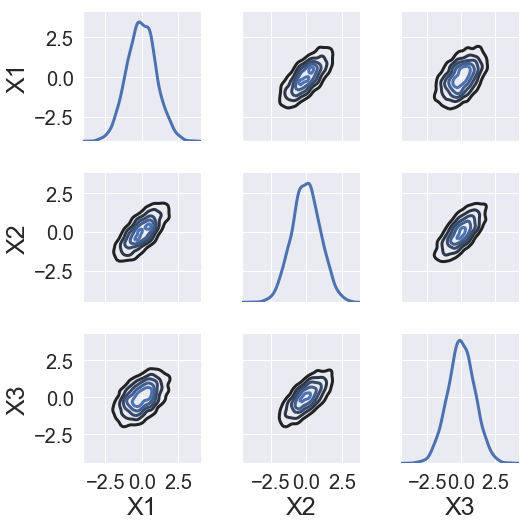

In [13]:
#sns.pairplot(chain_data)
g = sns.PairGrid(chain_data)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [72]:
chain_data.to_csv('../Data/chain.csv', index=False)

# 2 - Fork
(cf. e.g. the book of why)

$$X_1 <- X_2 -> X_3$$

$$X_2 \sim N(\mu=0, \sigma=1)$$
$$X_1 \sim p(X_1 | X_2) = N(\mu=\alpha_{12} X_2, \sigma=\sigma_{\epsilon_1})$$
$$X_3 \sim p(X_3 | X_2) = N(\mu=\alpha_{32} X_2, \sigma=\sigma_{\epsilon_3})$$

As before, I choose $\sigma(X_i) = 1$ for each variable and choose correlation coefficients $r_{12} = r_{21} = r_{32} = r$. Then,
$$\alpha_{12} = \alpha_{32} = r$$
$$\sigma(\epsilon_i) = \sqrt{1 - r^2},  \quad \quad i=1,3$$

The default choice will remain $r = \sqrt{1/2}$.

In [78]:
def generate_fork(n_samples, r):
    alpha = r
    sigeps = np.sqrt(1. - alpha**2)
    alpha_12, alpha_32, sigeps_1, sigeps_3 = alpha, alpha, sigeps, sigeps
    X2 = np.random.randn(n_samples)
    X1 = alpha_12 * X2 + sigeps_1 * np.random.randn(n_samples)
    X3 = alpha_32 * X2 + sigeps_3 * np.random.randn(n_samples)
    fork_data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
    return fork_data

In [79]:
fork_data = generate_fork(n_samples, r)

In [75]:
fork_data.std()

X1    0.996425
X2    1.001484
X3    1.006226
dtype: float64

In [76]:
fork_data.corr()

,X1,X2,X3
X1,1.000000,0.712665,0.503016
X2,0.712665,1.000000,0.706440
X3,0.503016,0.706440,1.000000


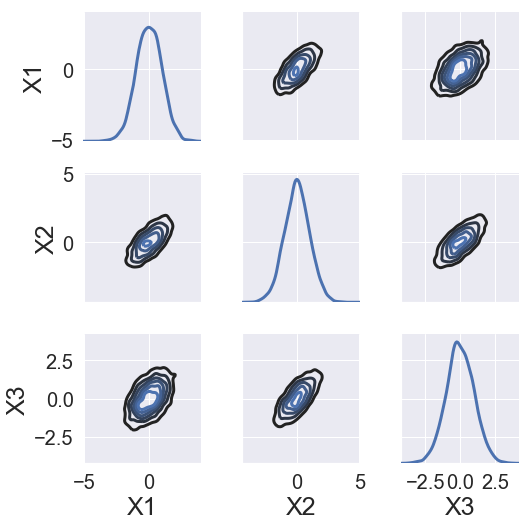

In [19]:
g = sns.PairGrid(fork_data)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

#### Note that this is the exact same distribution as the chain ditribution in Section 1

In [80]:
fork_data.to_csv('../Data/fork.csv', index=False)

# 3 - Collision

$$X_1 -> X_2 <- X_3$$



$$X_1 \sim N(\mu=0, \sigma=1)$$
$$X_3 \sim N(\mu=0, \sigma=1)$$
$$X_2 \sim p(X_2 | X_1, X_3) = N(\mu=\alpha_{21} X_1 + \alpha_{23} X_3,\sigma=\sigma(\epsilon_2))$$

As before, I choose $\sigma(X_i) = 1$ for each variable. I choose correlation coefficients $r_{21} = r_{23} = r$. Then,
$$\alpha_{21} = \alpha_{23} = r$$
$$\sigma(\epsilon_2) = \sqrt{1 - 2 r^2}$$

The default choice will remain $r = \sqrt{1/2}$.

In [81]:
def generate_collision(n_samples, r):
    alpha = r
    sigeps_2 = np.sqrt(1. - 2. * alpha**2)
    alpha_21, alpha_23 = alpha, alpha
    X1 = np.random.randn(n_samples)
    X3 = np.random.randn(n_samples)
    X2 = alpha_21 * X1 + alpha_23 * X3 + sigeps_2 * np.random.randn(n_samples)
    collision_data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3})
    return collision_data

In [82]:
n_samples = 20000
collision_data = generate_collision(n_samples, r)

In [21]:
collision_data.std()

X1    1.003546
X2    1.003497
X3    1.004999
dtype: float64

In [24]:
collision_data.corr()

,X1,X2,X3
X1,1.000000,0.703035,-0.001953
X2,0.703035,1.000000,0.709780
X3,-0.001953,0.709780,1.000000


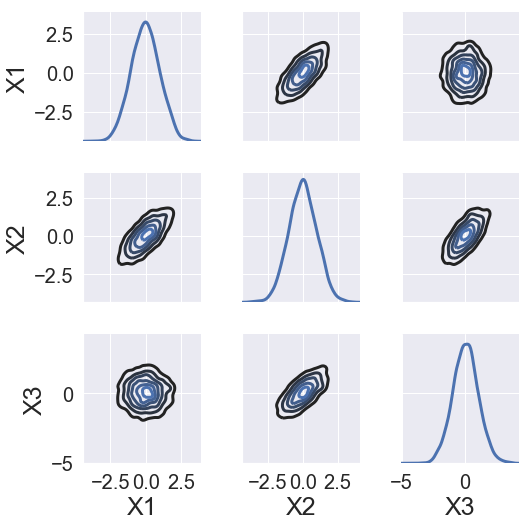

In [25]:
g = sns.PairGrid(collision_data)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

#### Note that now $X_1$ and $X_3$ are uncorrelated. This is a different distribution than the chain and fork.

In [83]:
collision_data.to_csv('../Data/collision.csv', index=False)

## Bayesian Network Reconstruction with Pomegranate

In [ ]:
from pomegranate import *

#### Create a discrete dataset (Pomegranate doesn't support continuous ones)

In [84]:
collision_data_discrete = (collision_data > 0).astype(int)

In [85]:
collision_data_discrete.to_csv('../Data/collision_discrete.csv', index=False)

In [25]:
collision_data_discrete.corr()

,X1,X2,X3
X1,1.000000,0.497042,0.002979
X2,0.497042,1.000000,0.505908
X3,0.002979,0.505908,1.000000


In [26]:
model_collision = BayesianNetwork("collision_diagram").from_samples(collision_data_discrete.values, algorithm='exact')


((), (0, 2), ())


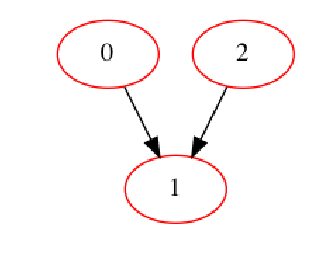

In [27]:
print model.structure
model.plot()

# 4 - M-diagram
See p. 161 of The Book of Why

$$ X_1 <- X_2 -> X_3 <- X_4 -> X_5 $$

$$
X_2 \sim N(\mu=0, \sigma=1)\\
X_4 \sim N(\mu=0, \sigma=1)\\
X_1 \sim p(X_1 | X_2) = N(\mu=X_2, \sigma=1)\\
X_5 \sim p(X_5 | X_4) = N(\mu=X_4, \sigma=1)\\
X_3 \sim p(X_3 | X_2, X_4) = N(\mu=X_2 + X_4, \sigma=1)
$$


In [86]:
def generate_Mdiagram(n_samples):
    X2 = np.random.randn(n_samples)
    X4 = np.random.randn(n_samples)
    X1 = X2 + np.random.randn(n_samples)
    X5 = X4 + np.random.randn(n_samples)
    X3 = X2 + X4 + np.random.randn(n_samples)
    M_data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'X5': X5})
    return M_data

In [87]:
n_samples = 20000
M_data = generate_Mdiagram(n_samples)

In [29]:
M_data.std()

X1    1.416998
X2    1.002380
X3    1.734538
X4    0.997591
X5    1.409580
dtype: float64

In [30]:
M_data.corr()

,X1,X2,X3,X4,X5
X1,1.000000,0.703305,0.406619,-0.006636,-0.003030
X2,0.703305,1.000000,0.576186,-0.005727,0.003393
X3,0.406619,0.576186,1.000000,0.573145,0.409026
X4,-0.006636,-0.005727,0.573145,1.000000,0.706363
X5,-0.003030,0.003393,0.409026,0.706363,1.000000


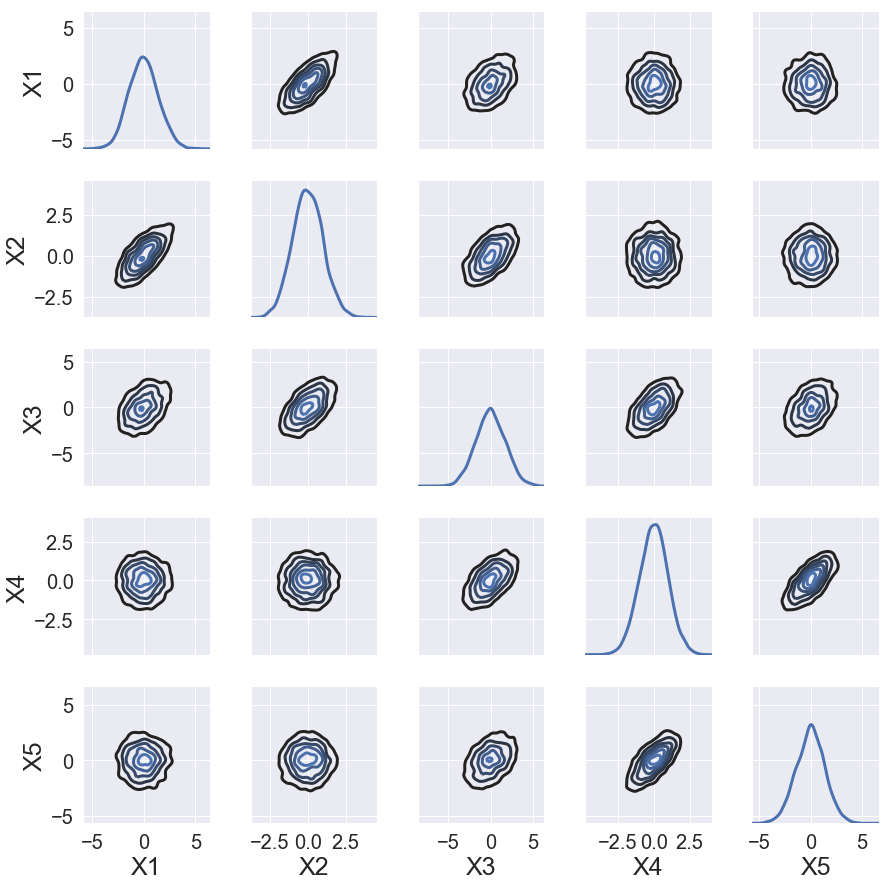

In [31]:
g = sns.PairGrid(M_data)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

#### Note that the two variables on the left are uncorrelated with the two variables on the right and everything is correlated with $X_3$. In particular, X_1 and X_5 are uncorrelated, which reflects the lack of a causal relation between the two (i.e. we did not need to correct for X_3; if we had done it, we would have introduced a correlation between X_1 and X_5, despite the lack of a causal relation between the two)

In [88]:
M_data.to_csv('../Data/Mdiagram.csv', index=False)

## Bayesian Network Reconstruction with Pomegranate

In [89]:
M_data_discrete = (M_data > 0).astype(int)

In [90]:
M_data_discrete.to_csv('../Data/Mdiagram_discrete.csv', index=False)

In [33]:
M_data_discrete.corr()

,X1,X2,X3,X4,X5
X1,1.000000,0.496627,0.265007,-0.005390,0.000199
X2,0.496627,1.000000,0.392793,-0.004432,-0.004997
X3,0.265007,0.392793,1.000000,0.397593,0.274002
X4,-0.005390,-0.004432,0.397593,1.000000,0.497608
X5,0.000199,-0.004997,0.274002,0.497608,1.000000


In [34]:
model_M = BayesianNetwork("M_diagram").from_samples(M_data_discrete.values, algorithm='exact')


((1, 2, 3), (), (1, 3, 4), (4,), ())


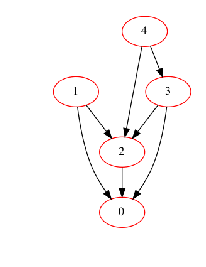

In [35]:
print model_M.structure
model_M.plot()

# 5 - Baroque diagram

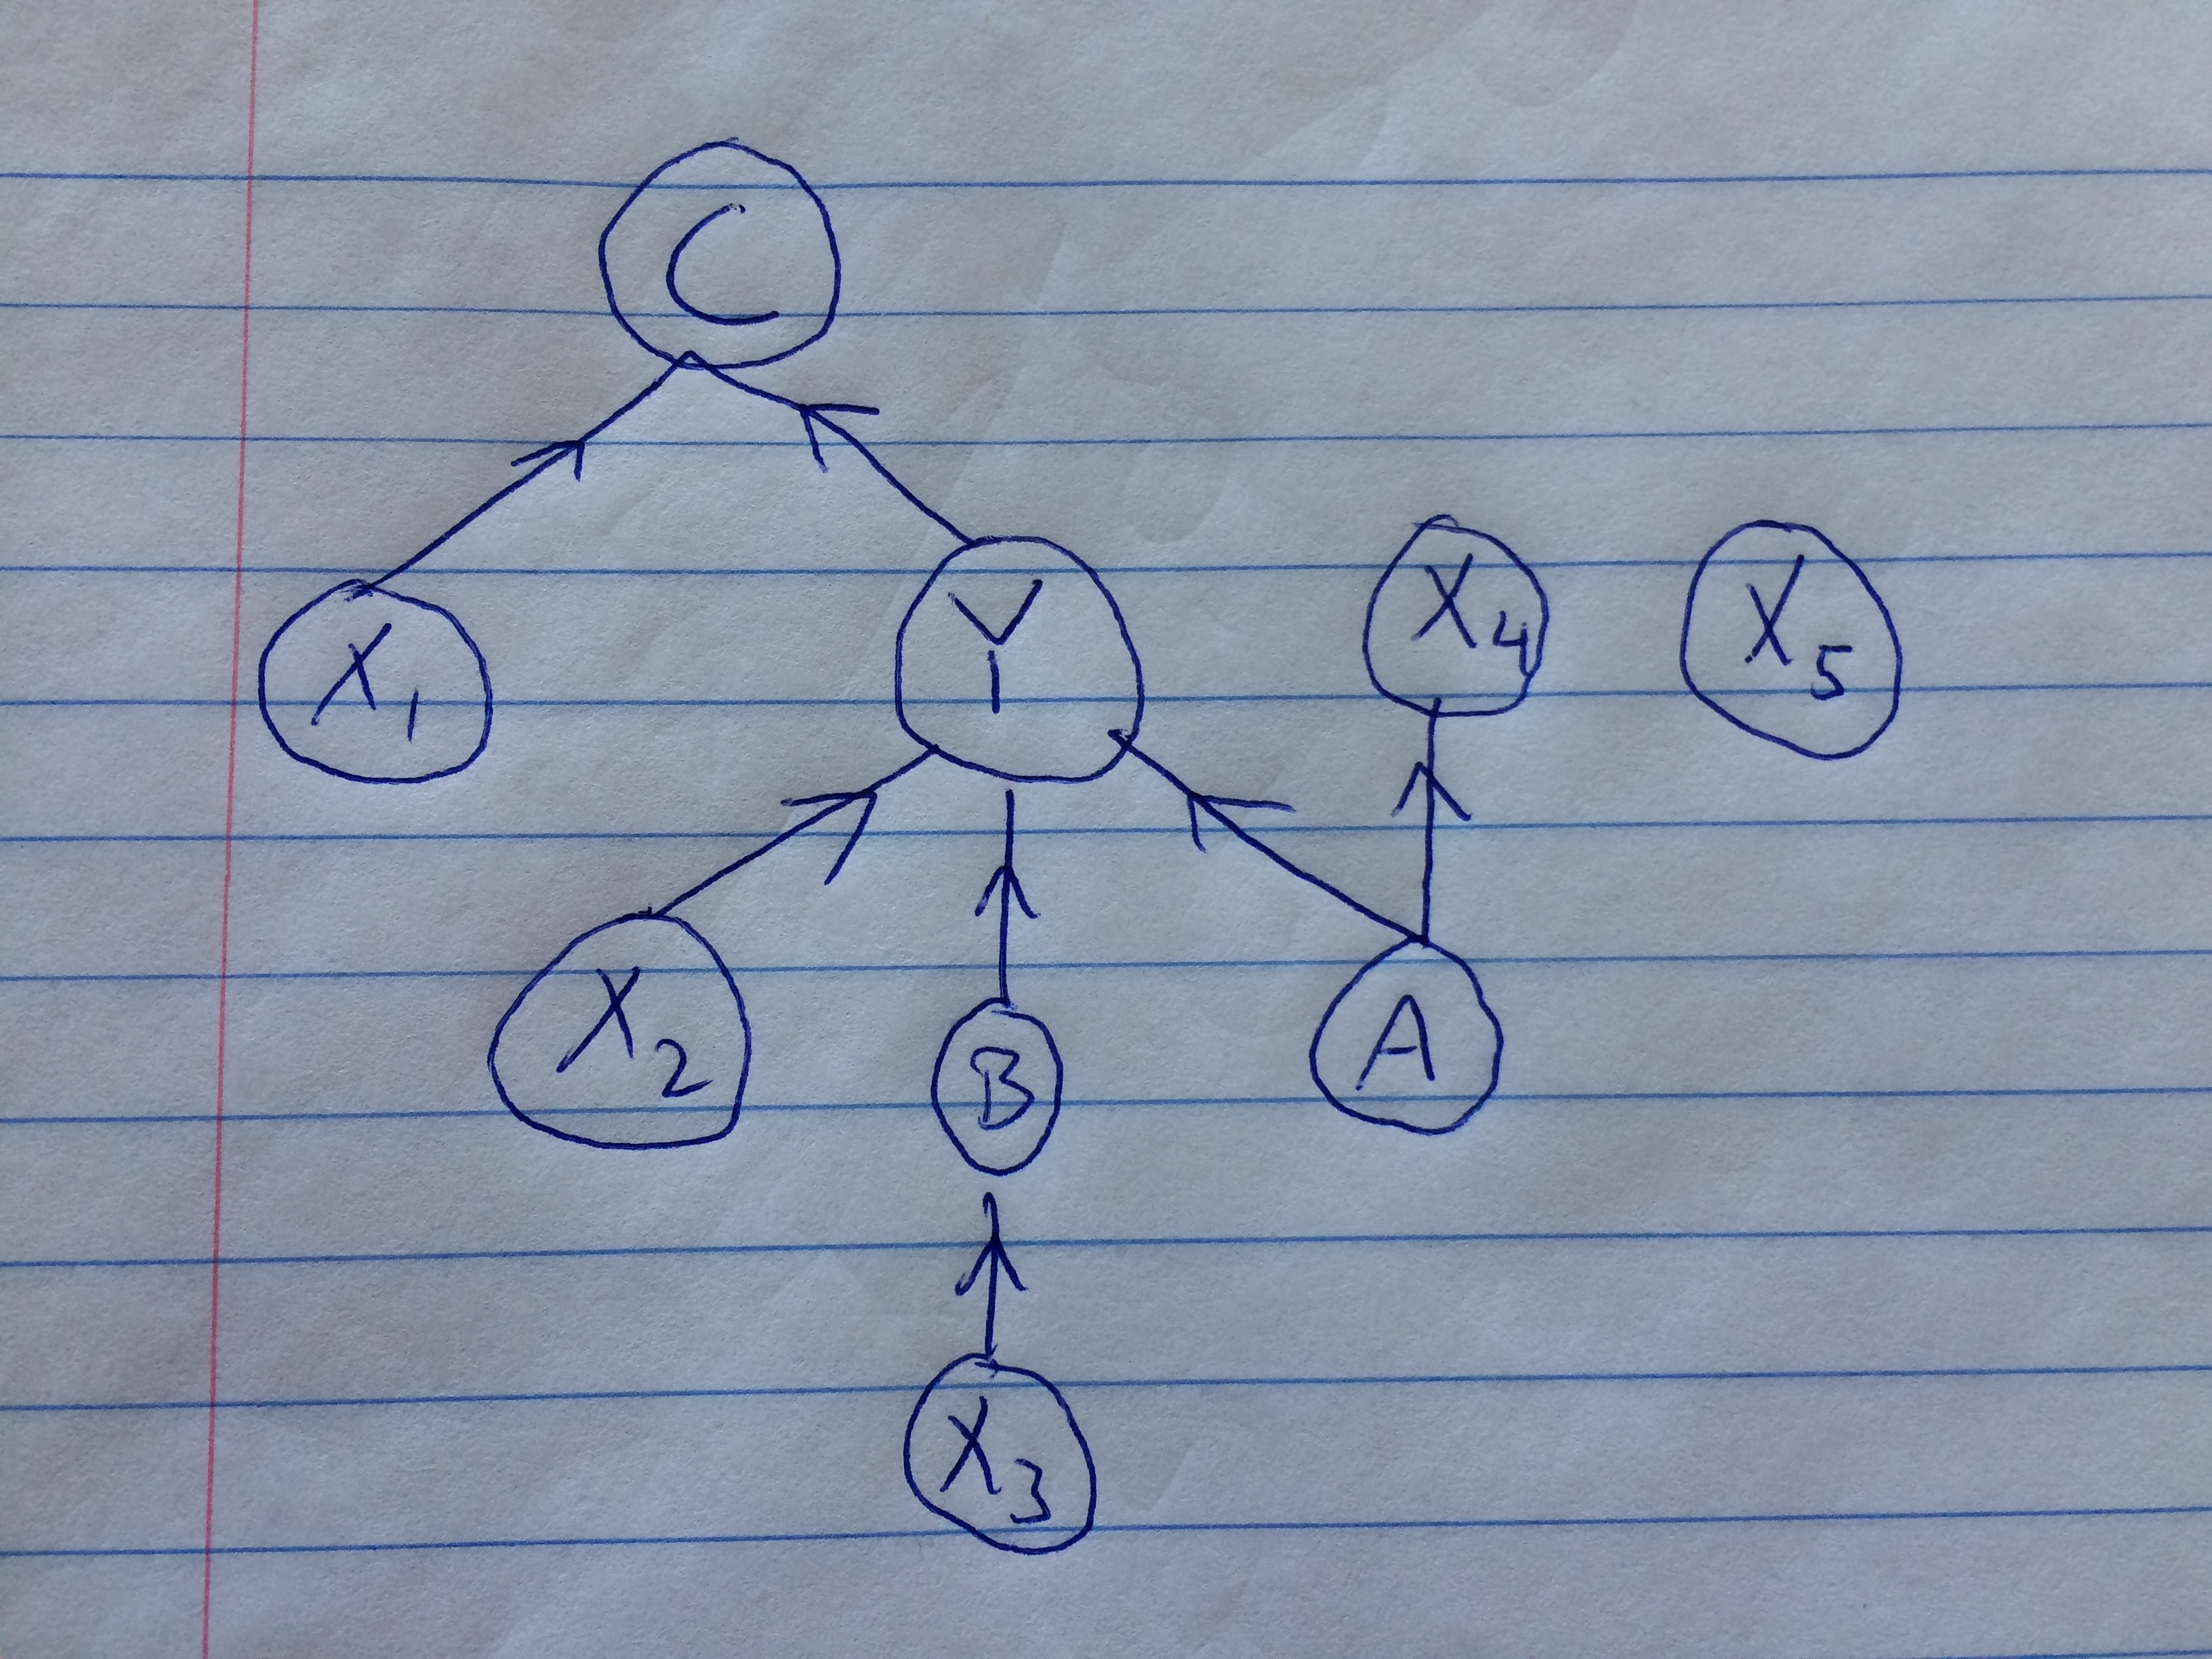

In [91]:
#<img src="../Images/baroque_net.jpg" style="width: 100px;">
from IPython.display import Image
Image("../Images/baroque_net.jpg", width=500, height=500)

Let's try a network with a target $Y$ and a number of features $X_i$ that contains:
* A collision: $X_1 -> C <- Y$
* A simple causal relationship: $X_2 -> Y$
* A chain: $X_3 -> B -> Y$
* A fork: $X_4 <- A -> Y$
* A "red-herring variable" independent of everything else: $X_5$


$$
X_1 \sim N(\mu=0, \sigma=\sigma(\epsilon))\\
X_2 \sim N(\mu=0, \sigma=\sigma(\epsilon))\\
X_3 \sim N(\mu=0, \sigma=\sigma(\epsilon))\\
A \sim N(\mu=0, \sigma=\sigma(\epsilon))\\
X_4 \sim p(X_4 | A) = N(\mu=A, \sigma=\sigma(\epsilon))\\
B \sim p(B | X_3) = N(\mu=X_3, \sigma=\sigma(\epsilon))\\
Y \sim p(Y | X_2, B, A) = N(\mu = X_2 + B + A, \sigma=\sigma(\epsilon))\\
C \sim p(C | X_1, Y) = N(\mu = X_1 + Y, \sigma=\sigma(\epsilon))\\
X_5 \sim N(\mu=0, \sigma=\sigma(\epsilon))
$$



In [92]:
def generate_baroque(n_samples, sigeps):
    X1 = sigeps * np.random.randn(n_samples)
    X2 = sigeps * np.random.randn(n_samples)
    X3 = sigeps * np.random.randn(n_samples)
    A = sigeps * np.random.randn(n_samples)
    X4 = A + sigeps * np.random.randn(n_samples)
    B = X3 + sigeps * np.random.randn(n_samples)
    Y = X2 + B + A + sigeps * np.random.randn(n_samples)
    C = X1 + Y + sigeps * np.random.randn(n_samples)
    X5 = sigeps * np.random.randn(n_samples)
    
    baroque_data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'X5': X5, 'Y': Y, 'A': A, 'B': B, 'C': C})
    return baroque_data

In [93]:
n_samples = 20000
baroque_data = generate_baroque(n_samples, 0.5)

In [40]:
baroque_data.std()

A     0.503063
B     0.704948
C     1.319881
X1    0.498896
X2    0.502336
X3    0.499526
X4    0.710267
X5    0.499771
Y     1.121169
dtype: float64

In [41]:
baroque_data.corr()

,A,B,C,X1,X2,X3,X4,X5,Y
A,1.000000,-0.003540,0.381105,-0.007814,0.013457,0.006278,0.705214,0.003532,0.455726
B,-0.003540,1.000000,0.530202,-0.001588,-0.003839,0.710731,-0.004962,-0.004856,0.627753
C,0.381105,0.530202,1.000000,0.373875,0.381910,0.378087,0.265607,0.004888,0.844256
X1,-0.007814,-0.001588,0.373875,1.000000,0.002146,-0.005384,-0.000600,-0.005132,-0.004792
X2,0.013457,-0.003839,0.381910,0.002146,1.000000,-0.001353,0.005354,0.008180,0.448950
X3,0.006278,0.710731,0.378087,-0.005384,-0.001353,1.000000,-0.000043,-0.005117,0.448936
X4,0.705214,-0.004962,0.265607,-0.000600,0.005354,-0.000043,1.000000,-0.000045,0.316035
X5,0.003532,-0.004856,0.004888,-0.005132,0.008180,-0.005117,-0.000045,1.000000,0.001612
Y,0.455726,0.627753,0.844256,-0.004792,0.448950,0.448936,0.316035,0.001612,1.000000


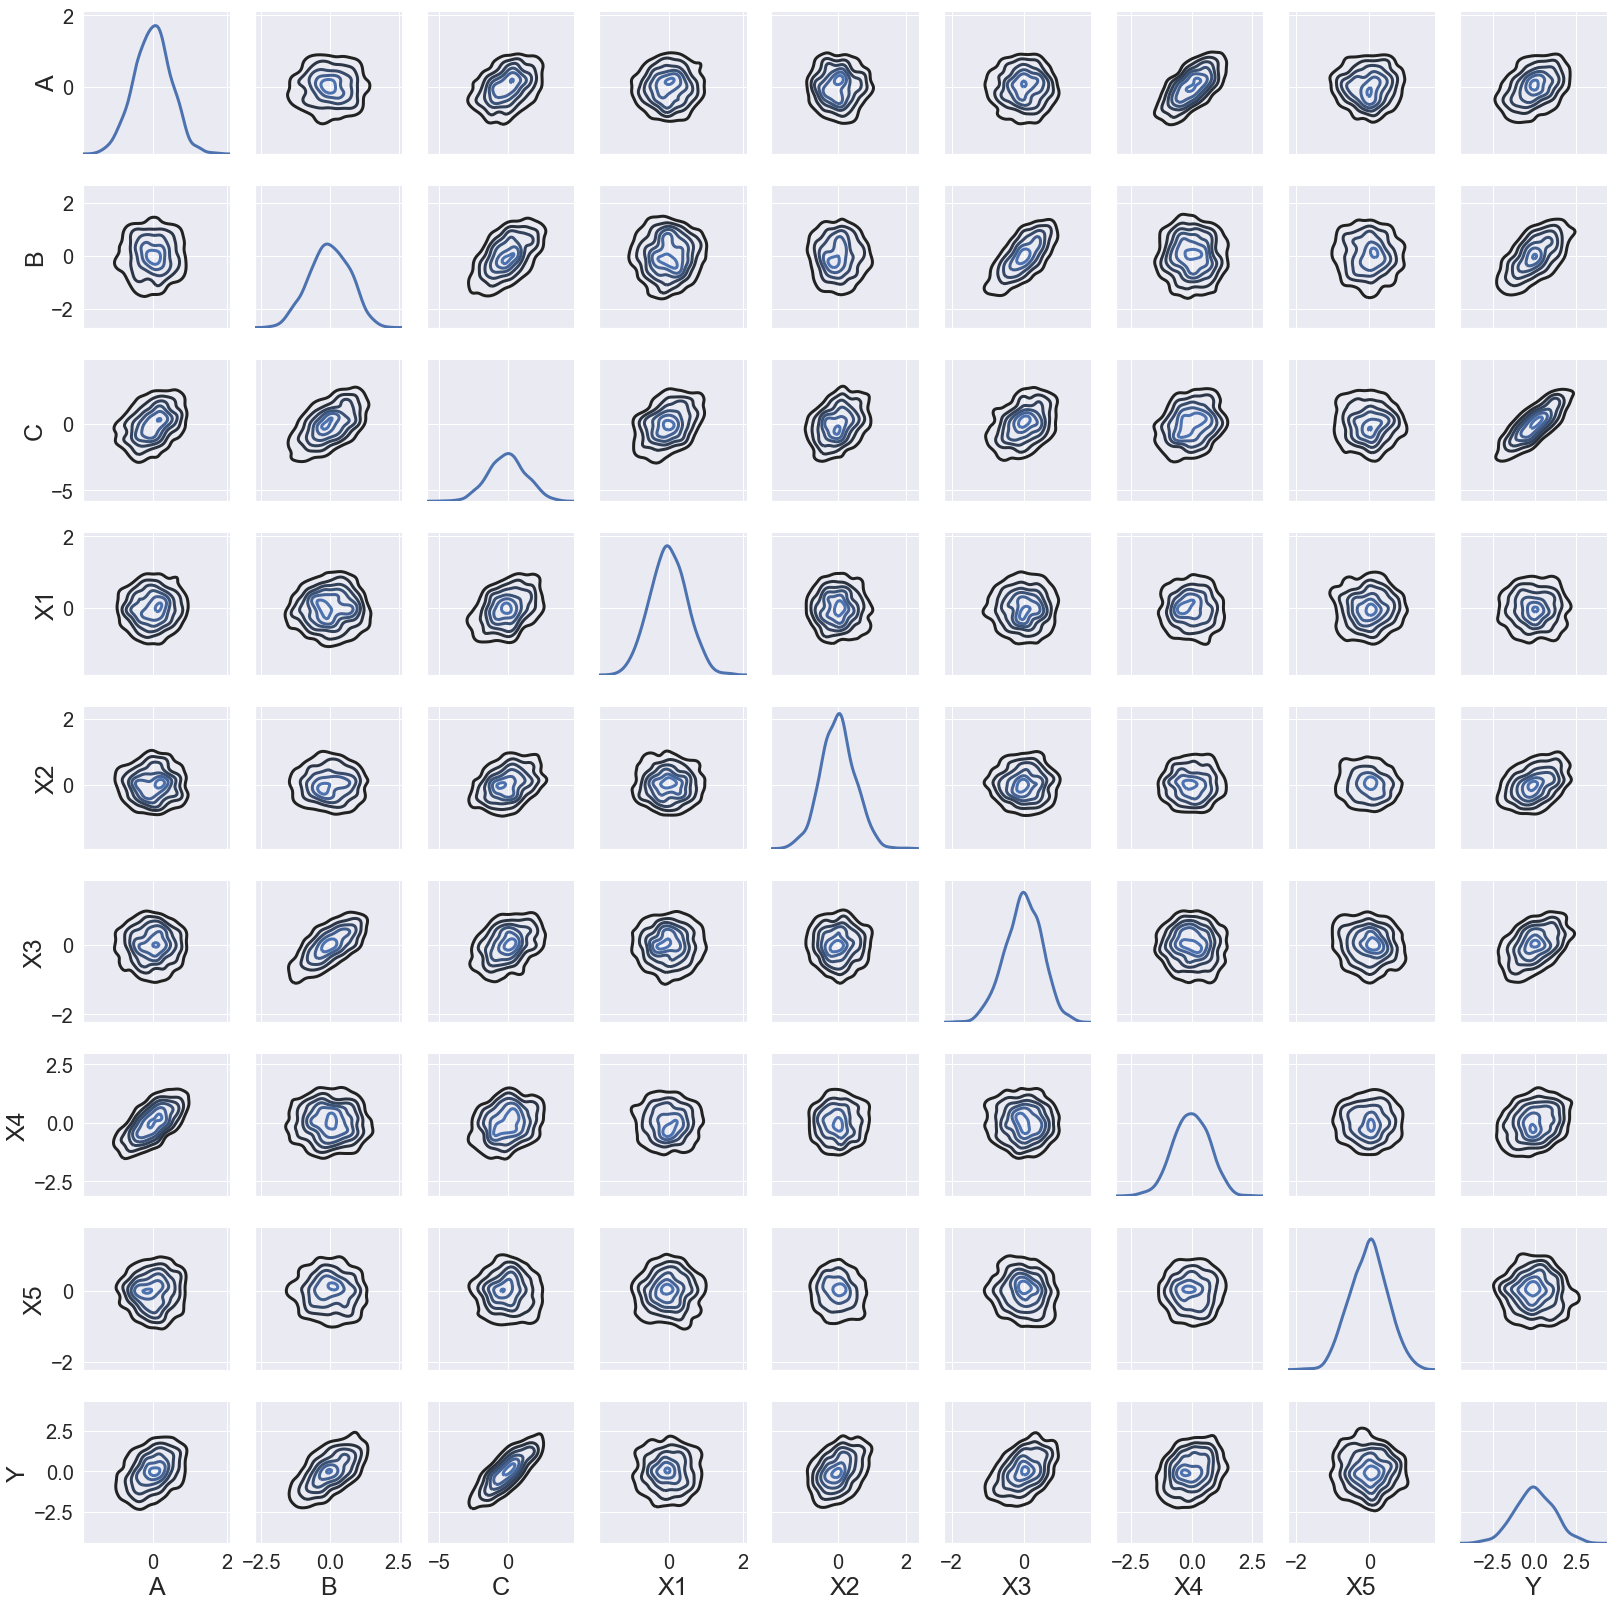

In [42]:
g = sns.PairGrid(baroque_data.sample(n=1000))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

In [94]:
baroque_data.to_csv('../Data/baroque_network.csv', index=False)

## Bayesian Network Reconstruction with Pomegranate

In [95]:
baroque_data_discrete = (baroque_data > 0).astype(int)

In [96]:
baroque_data_discrete.to_csv('../Data/baroque_network_discrete.csv', index=False)

In [46]:
baroque_data_discrete.corr()

,A,B,C,X1,X2,X3,X4,X5,Y
A,1.000000,0.008197,0.260473,0.001420,0.014428,0.009489,0.494389,0.011561,0.305774
B,0.008197,1.000000,0.356708,-0.000397,0.011404,0.497900,0.002597,-0.008607,0.437215
C,0.260473,0.356708,1.000000,0.243553,0.253770,0.241989,0.177265,0.004220,0.642068
X1,0.001420,-0.000397,0.243553,1.000000,0.003573,-0.003289,0.006822,-0.009560,0.010245
X2,0.014428,0.011404,0.253770,0.003573,1.000000,0.008115,-0.001370,-0.002146,0.306081
X3,0.009489,0.497900,0.241989,-0.003289,0.008115,1.000000,-0.001112,-0.011522,0.295092
X4,0.494389,0.002597,0.177265,0.006822,-0.001370,-0.001112,1.000000,0.005357,0.208564
X5,0.011561,-0.008607,0.004220,-0.009560,-0.002146,-0.011522,0.005357,1.000000,0.005712
Y,0.305774,0.437215,0.642068,0.010245,0.306081,0.295092,0.208564,0.005712,1.000000


In [54]:
model_baroque = BayesianNetwork("baroque_diagram").from_samples(baroque_data_discrete.values, algorithm='exact')
model_baroque = BayesianNetwork("baroque_diagram").from_samples(baroque_data_discrete.values, algorithm='exact')

((6,), (), (0, 1, 4, 8), (2, 8), (), (1, 8), (), (), (0, 1, 4, 6))


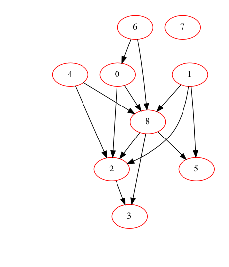

In [55]:
print model_baroque.structure
model_baroque.plot()